In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

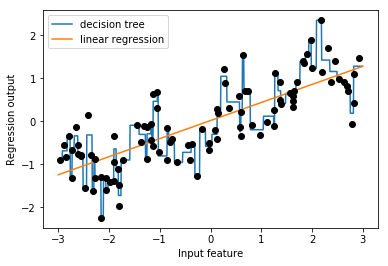

In [3]:
X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

waveデータセットでの線形回帰と決定木の比較

特徴量の入力レンジ(ここでは-3～3)を固定数のビン、例えば10個のビンに分割することを考える。

データポイントは、どのビンに分類されたかで表現される。これにはまずビンを定義しなければならない。

In [4]:
bins = np.linspace(-3, 3, 11)
print("bins: {}".format(bins))

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]


最初のビンには-3から-2.4までのすべての数が入り、次のビンには-2.4から-1.8までの数が入る。

次に、個々のデータポイントがどのビンに入るかを記録する。これは、np.digitize関数で簡単にできる。

In [5]:
which_bin = np.digitize(X, bins=bins)
print("\nData points:\n", X[:5])
print("\nBin membership for data points:\n", which_bin[:5])


Data points:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


waveデータセットの単一の連続値入力特徴量の、どのビンにデータポイントが入っているかを表現したカテゴリ特徴量への置き換えを行った。

このデータにscikit-learnモデルを適用するには、この離散値特徴量をワンホットエンコーディングに変換する必要がある。

　⇒ワンホットエンコーディングしないと、連続値として扱われてしまい、正しく適合できないため。

これにはpreprocessingモジュールのOneHotEncoderを用いる。

OneHotEncoderはpandas.get_dummiesと同じ機能を持つが、今のところ整数値で表現されたカテゴリ変数しか扱うことができない。

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
# OneHotEncoderで変換する
encoder = OneHotEncoder(sparse=False)
# encoder.fitでwhich_binに現れる整数値のバリエーションを確認
encoder.fit(which_bin)
# tansformでワンホットエンコーディングを行う
X_binned = encoder.transform(which_bin)
print(X_binned[:5])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


10ビンを指定したので、変換されたデータセットX_binnedには10個の特徴量ができている。

In [8]:
print("X_binned.shape: {}".format(X_binned.shape))

X_binned.shape: (100, 10)


線形回帰モデルと決定木モデルをこのワンホットエンコーディングデータに対して作り直してみる。

Text(0.5,0,'Input feature')

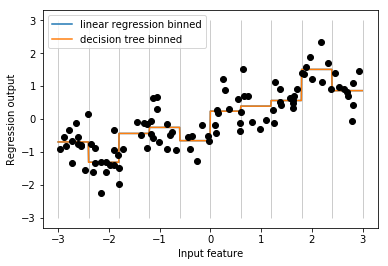

In [9]:
line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

ビニング特徴量を用いた線形回帰と決定木の比較

In [10]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(100, 11)


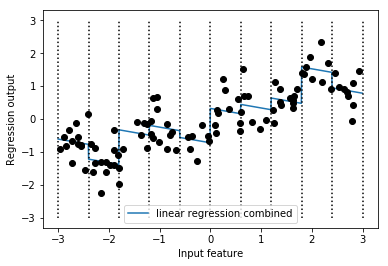

In [11]:
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

この例では、モデルは個々のビンに対してオフセットと傾きを学習する。傾きは下向きで、すべてのビンで共有されている。
x軸は1つしかなく、したがって傾きは1つしかないため。
ビンごとに傾きがあれば役に立つ。

これを実現するには、データポイントがどのビンに入っているかを示す特徴量とx軸のどこにあるかを示す特徴量の交互作用もしくは積を、特徴量として加えればよい。

In [12]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(100, 20)


これでデータセットの特徴量は20になった。どのビンにデータポイントが入っているかを示すビン番号特徴量と、もとの特徴量 x ビン番号である。

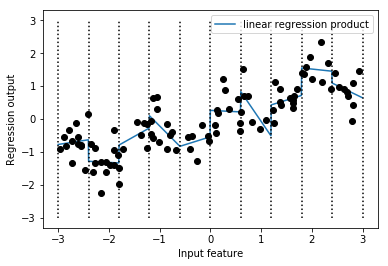

In [13]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

個々のビンがそれぞれオフセットと傾きを持つようになっている。

ビニングは、連続値特徴量を拡張する方法の1つである。もう1つの方法はもとの特徴量の多項式を使うことである。
ある特徴量xに対して、x ** 2, x ** 3, x ** 4を考えるのだ。
これはpreprocessingモジュールのPolynomialFeaturesに実装されている。

In [15]:
from sklearn.preprocessing import PolynomialFeatures

In [16]:
# x ** 10までの多項式を加える。
# デフォルトの"include_bias=True"だと、常に1となる特徴量を加える
poly = PolynomialFeatures(degree=10, include_bias=False)

In [17]:
poly.fit(X)
X_poly = poly.transform(X)

In [18]:
print("X_poly.shape: {}".format(X_poly.shape))

X_poly.shape: (100, 10)


X_polyの内容をXと比較してみる

In [19]:
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


In [20]:
print("Polynomical feature names:\n{}".format(poly.get_feature_names()))

Polynomical feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


X_polyの最初の要素はXと同じで、その他の要素は、最初の要素のべき乗となっている

多項式特徴量を線形回帰モデルと組み合わせると、古典的な**多項式回帰モデル**になる

In [22]:
reg = LinearRegression().fit(X_poly, y)

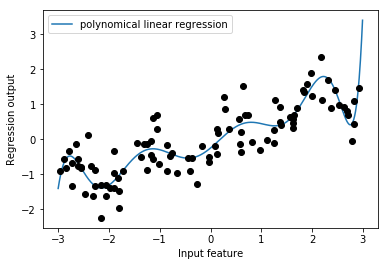

In [23]:
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomical linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")